## Loading packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras import layers

Using TensorFlow backend.


## Load MoodyLyrics data

In [73]:
ml_df = pd.read_csv('D:/Data-x data/MoodyLyrics/ml_balanced_v2.csv', sep = ';', header = 0);
ml_df.head()

,Index,Artist,Title,Mood
0,ML1,Usher,There Goes My Baby,relaxed
1,ML2,Da'Ville,On My Mind,relaxed
2,ML3,Rihanna,Rockstar 101,relaxed
3,ML4,J. Holiday,Bed,relaxed
4,ML5,Morgan Heritage,Don't Haffi Dread,angry


## Grab Spotify API data into the dataset 

### Setting up Spotify API

In [42]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = '6188e6e99ee3432e98f8fe2e01f19f3e'
client_secret = 'f8b3bda411a14edf86be0513c6217e05'

# Define a function that can find the uri #
# Inspiration: https://nitratine.net/blog/post/finding-emotion-in-music-with-python/ #

def find_uri(title, artist):
    # Set up the credentials manager #
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    sp.trace=False
    search_querry = title + ' ' + artist
    result = sp.search(search_querry)
    for i in result['tracks']['items']:
        # Find a songh that matches title and artist
        if (i['artists'][0]['name'] == artist) and (i['name'] == title):
            return i['uri']
            
        else:
            try:
                # Just take the first song returned by the search (might be named differently)
                return result['tracks']['items'][0]['uri']
            except:
                # No results for artist and title
                print ("Cannot Find URI")
                return np.nan

In [47]:
uri_list = []

# Find all the uris #
j = 0

ml_len = ml_df.shape[0]

for artist, song in zip(ml_df['Artist'], ml_df['Title']):
    uri_list.append(find_uri(song, artist))
    
    if j % 100 == 0:
        print('%s / %s' % (j, ml_len))
    
    j += 1

0 / 2000
100 / 2000
200 / 2000
300 / 2000
400 / 2000
500 / 2000
600 / 2000
700 / 2000
800 / 2000
900 / 2000
1000 / 2000
1100 / 2000
1200 / 2000
1300 / 2000
1400 / 2000
1500 / 2000
1600 / 2000
1700 / 2000
1800 / 2000
1900 / 2000


In [49]:
# Define function to get Spotify features #
def find_feat(uri):
    if uri == None:
        feat_dict = {'bpm': np.nan,
                     'nrgy': np.nan,
                     'dnce': np.nan,
                     'dB': np.nan,
                     'live': np.nan,
                     'val': np.nan,
                     'dur': np.nan,
                     'acous': np.nan,
                     'spch': np.nan,
                     'pop': np.nan}
    else:
        client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
        sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
        sp.trace=False
        features = sp.audio_features(uri)
    
        feat_dict = {'bpm': features[0]['tempo'],
                     'nrgy': features[0]['energy'],
                     'dnce': features[0]['danceability'],
                     'dB': features[0]['loudness'],
                     'live': features[0]['liveness'],
                     'val': features[0]['valence'],
                     'dur': features[0]['duration_ms'],
                     'acous': features[0]['acousticness'],
                     'spch': features[0]['speechiness'],
                     'pop': features[0]['instrumentalness']}
        
    return feat_dict

In [55]:
# Use song uri's to find spotify data #

# Create empty lists #
feat = {'bpm': [], 'nrgy': [], 'dnce': [],
        'dB': [], 'live': [], 'val': [],
        'dur': [], 'acous': [], 'spch': [],
        'pop': []}

k = 0

for uri in uri_list:
    feats = find_feat(uri)
    # Append #
    feat['bpm'].append(feats['bpm'])
    feat['nrgy'].append(feats['nrgy'])
    feat['dnce'].append(feats['dnce'])
    feat['dB'].append(feats['dB'])
    feat['live'].append(feats['live'])
    feat['val'].append(feats['val'])
    feat['dur'].append(feats['dur'])
    feat['acous'].append(feats['acous'])
    feat['spch'].append(feats['spch'])
    feat['pop'].append(feats['pop'])
    
    if k % 100 == 0:
        print('%s / %s' % (k, len(uri_list)))
    
    k += 1




0 / 2000
100 / 2000
200 / 2000
300 / 2000
400 / 2000
500 / 2000
600 / 2000
700 / 2000
800 / 2000
900 / 2000
1000 / 2000
1100 / 2000
1200 / 2000
1300 / 2000
1400 / 2000
1500 / 2000
1600 / 2000
1700 / 2000
1800 / 2000
1900 / 2000


### Append to dataframe

In [74]:
ml_df['uri'] = uri_list
ml_df['bpm'] = feat['bpm']
ml_df['nrgy'] = feat['nrgy']
ml_df['dnce'] = feat['dnce']
ml_df['dB'] = feat['dB']
ml_df['live'] = feat['live']
ml_df['val'] = feat['val']
#ml_df['val'] = ml_df['val']*100
ml_df['dur'] = feat['dur']
ml_df['acous'] = feat['acous']
ml_df['spch'] = feat['spch']
ml_df['pop'] = feat['pop']

### Clean dataframe for NaN values

In [106]:
ml_df = ml_df.dropna(axis = 0)

ml_df.isnull().sum(axis = 0)

Index     0
Artist    0
Title     0
Mood      0
uri       0
bpm       0
nrgy      0
dnce      0
dB        0
live      0
val       0
dur       0
acous     0
spch      0
pop       0
dtype: int64

In [107]:
ml_df.head()

,Index,Artist,Title,Mood,uri,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,ML1,Usher,There Goes My Baby,relaxed,spotify:track:6IUiqtI8tE49sqGbmtrNd8,77.468,0.520,0.626,-8.077,0.130,0.257,281293.0,0.1750,0.0892,0.000000
1,ML2,Da'Ville,On My Mind,relaxed,spotify:track:3ZTHqAgrKgfS1NSZEdM9Io,167.852,0.574,0.628,-6.958,0.066,0.807,203373.0,0.0308,0.0550,0.000011
2,ML3,Rihanna,Rockstar 101,relaxed,spotify:track:5rXDTihGQ3TkYE3pmraAmH,170.697,0.650,0.343,-4.624,0.646,0.315,238893.0,0.0299,0.0909,0.000000
3,ML4,J. Holiday,Bed,relaxed,spotify:track:6TlRNJaezOdzdECnQeRuMM,127.901,0.606,0.684,-7.268,0.058,0.723,275107.0,0.1700,0.0504,0.000000
4,ML5,Morgan Heritage,Don't Haffi Dread,angry,spotify:track:5HdF2l0OkkRfpjac0NEoJR,140.930,0.733,0.621,-6.365,0.452,0.829,496160.0,0.0326,0.0537,0.000000


### Save to new file

In [75]:
ml_df.to_csv('D:/Data-x data/ml_mod_v1.csv', sep = ';')

### Prepare data for model-use

In [122]:
X = np.array(ml_df.loc[:, ['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']])
Y = ml_df['Mood']

labelEncoder=LabelEncoder()
y = labelEncoder.fit_transform(Y)

from keras.utils import np_utils
# y = np_utils.to_categorical(y)

#### Split the data into train/test

In [123]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

### Set up the model 

In [134]:
# Build random forest #
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(min_samples_leaf = 5, random_state = 0, n_estimators = 1000,
                            criterion = 'gini', max_features = None, n_jobs = -1, oob_score = True)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [144]:
y_pred = rf_model.predict(X_test)
y_pred_v2 = labelEncoder.inverse_transform(y_pred)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy = %.2f%%' % (accuracy_score(y_true = Y_test, y_pred = y_pred)*100))
print('Precision =', precision_score(y_true = Y_test, y_pred = y_pred, average = None))
print('Recall =', recall_score(y_true = Y_test, y_pred = y_pred, average = None))
print('F1 score =', f1_score(y_true = Y_test, y_pred = y_pred, average = None))

Accuracy = 40.77%
Precision = [0.46721311 0.34259259 0.42156863 0.37931034]
Recall = [0.64772727 0.38947368 0.40566038 0.21782178]
F1 score = [0.54285714 0.36453202 0.41346154 0.27672956]


In [145]:
# Build neural network
# inp = Input(name='inputs', shape = X_train.shape)
# x = LSTM(32)(inp)
# x = Dense(256, name='FC1')(inp)
# x = Activation('relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(4,name='out_layer')(x)
# out = Activation('softmax')(x)
# model = Model(inputs = inp, outputs=out)
# 
# model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(), metrics=['accuracy'])
# history=model.fit(X_train, Y_train, batch_size=128, epochs=40, validation_split=0.2)

## Load old data with lyrics 

In [13]:
df_lyr = pd.read_csv('D:/Data-x data/Spotify_v3.csv', sep = ';', index_col = 0)
df_lyr.head()

,title,artist,top genre,year,added,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,title_core,lyrics,lyric_pos_sent,lyric_neg_sent,Pos/Neg
0,It's You - Radio Edit,Syn Cole,big room,2015,2017‑10‑07,128,83,65,-4,13,49,212,11,5,58,It's You,"[Verse 1: Syn Cole]\r\nPaints like a picture, ...",0.191,0.100,1
1,Show You Love,Kato,danish hip hop,2017,2018‑10‑25,124,83,69,-5,7,66,183,29,7,47,Show You Love,[Verse 1: Hailee Steinfeld]\r\nI'll do this th...,0.363,0.025,1
2,Just Us,Said the Sky,chillstep,2018,2019‑02‑28,109,58,75,-5,10,33,163,19,6,68,Just Us,[Verse 1]\r\nBeen so long\r\nSince I had someo...,0.050,0.041,1
3,Warriors - Rob Adans Remix,Nicky Romero,big room,2015,2017‑05‑17,127,89,67,-3,66,65,312,0,4,36,Warriors,[Verse]\r\nEmerging from the dust and rubble\r...,0.000,0.111,0
4,The Sweet Escape,Gwen Stefani,australian pop,2006,2016‑01‑08,120,77,75,-3,16,74,246,21,3,66,The Sweet Escape,"[Intro: Akon]\r\nKonvict, Konvict, Konvict\r\n...",0.123,0.127,0


**Comment:** <br>
The variables that are used in the before made Random forest model is:
- bpm: [Min = 49, Max = 204]
- nrgy: [Min = 0, Max = 99]
- dnce: [Min = 7, Max = 97]
- dB: [Min = -36, Max = -1]
- live: [Min = 2, Max = 97]
- val: [Min = 3, Max = 97]
- dur: [Min = 58, Max = 695]
- acous: [Min = 0, Max = 100]
- spch: [Min = 2, Max = 62]
- pop: [Min = 0, Max = 98] 

# Face data

## Load facial images data 

In [14]:
#import cv2
import os
from os import walk

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation,Flatten
from keras.optimizers import Adam
import numpy as np
import pandas as pd

from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import History

In [15]:
cwd = os.getcwd()
cwd

'/home/rlangergaard/Notebooks'

In [16]:
df_face = pd.read_csv('/home/rlangergaard/fer2013_(1).csv', sep = ',')
df_face.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Split the data

In [17]:
df_face_train = df_face.loc[df_face['Usage'] == 'Training']
df_face_train.shape

(28709, 3)

In [18]:
df_face_test = df_face.loc[df_face['Usage'] != 'Training']
df_face_test.shape

(7178, 3)

In [19]:
# Training data
X_train = df_face_train['pixels']
Y_train = df_face_train['emotion']

# Test data
X_test = df_face_test['pixels']
Y_test = df_face_test['emotion']
X_test.index = range(0, len(X_test))
Y_test.index = range(0, len(Y_test))

### Define preparation functions

In [20]:
def img_to_matrix(imagePath):
    image=cv2.imread(imagePath)
    image=cv2.resize(image, (48,48))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

In [21]:
def prepare_data(path):
    X=[]
    Y=[]
    labels = []
    for (_, dirnames, _) in walk(path):
        labels.extend(dirnames)
    for label in labels:
        for root, dirs, files in os.walk(os.path.abspath(path+'/'+label)):
            for file in files:
                imagePath=root +'/'+ file
                image=img_to_matrix(imagePath)
                X.append(image)
                Y.append([int(label)])
    return X,Y

In [22]:
def preprocess(X,Y):
    flat_X = np.array(X)
    flat_Y = np.array(Y)
    flat_X = flat_X.astype('float32')
    flat_X/=255
    flat_Y = keras.utils.to_categorical(flat_Y, num_classes)
    return flat_X,flat_Y

In [23]:
def str_pix_to_arr(X):
    arr = np.array(list(map(int, X[0].split(' '))))
    arr = arr.astype('float32')
    arr /= 255
    arr = arr.reshape(-1, 48, 48, 1)
    for i in range(1, len(X)):
        tmp = np.array(list(map(int, X[i].split(' '))))
        tmp = tmp.astype('float32')
        tmp /= 255
        tmp = tmp.reshape(-1, 48, 48, 1)
    
        arr = np.append(arr, tmp, axis = 0)
        
        if (i / len(X)) % 0.1 == 0:
            print('Progress = %s%%' % ((i / len(X))*100))
        
    print(arr.shape)
        
    return arr

In [24]:
def Y_to_cat(Y, num_classes):
    Y_tmp = np.array(Y)
    Y_tmp = keras.utils.to_categorical(Y_tmp, num_classes)
    
    print(Y_tmp.shape)
    
    return Y_tmp
    

### Modify data

In [25]:
X_train = str_pix_to_arr(X_train)
X_test = str_pix_to_arr(X_test)

(28709, 48, 48, 1)
(7178, 48, 48, 1)


In [46]:
print('Shape of training input =', X_train.shape)
print('Shape of test input =', X_test.shape)

Shape of training input = (28709, 48, 48, 1)
Shape of test input = (7178, 48, 48, 1)


In [27]:
Y_train = Y_to_cat(Y_train, len(set(Y_train)))
Y_test = Y_to_cat(Y_test, len(set(Y_test)))

(28709, 7)
(7178, 7)


### Build CNN with to predict mood from image

In [15]:
num_classes = len(Y_train[0])
print('Number of classes =', num_classes)

Number of classes = 7


In [16]:
################### Build the neural network ##################

# Inspiration https://github.com/achyuta26/MusicalFace/blob/master/train_cnn_face.py #

face_CNN = Sequential()

#1st block
face_CNN.add(Conv2D(64, (3,3), strides = (1,1), padding='same',
                 input_shape = X_train.shape[1:],
                   kernel_initializer="lecun_uniform",
                   kernel_regularizer=regularizers.l2(0)))
face_CNN.add(BatchNormalization())
face_CNN.add(Activation('tanh'))
face_CNN.add(MaxPooling2D(pool_size=(2, 2)))
face_CNN.add(Dropout(0.25))

#2nd block
face_CNN.add(Conv2D(128, (5,5), strides = (1,1),kernel_regularizer=regularizers.l2(0)))
face_CNN.add(BatchNormalization())
face_CNN.add(Activation('tanh'))
face_CNN.add(MaxPooling2D(pool_size=(2, 2)))
face_CNN.add(Dropout(0.25))


#3rd block
face_CNN.add(Conv2D(512, (3,3), strides = (1,1), padding='same',kernel_regularizer=regularizers.l2(0)))
face_CNN.add(BatchNormalization())
face_CNN.add(Activation('tanh'))
face_CNN.add(MaxPooling2D(pool_size=(2, 2)))
face_CNN.add(Dropout(0.5))

#4th block
face_CNN.add(Conv2D(512, (3,3), strides = (1,1), padding='same',kernel_regularizer=regularizers.l2(0)))
face_CNN.add(BatchNormalization())
face_CNN.add(Activation('tanh'))
face_CNN.add(MaxPooling2D(pool_size=(2, 2)))
face_CNN.add(Dropout(0.1))


#5th block
face_CNN.add(Flatten())
face_CNN.add(Dense(256,kernel_initializer="lecun_uniform"))
face_CNN.add(BatchNormalization())
face_CNN.add(Activation('relu'))
face_CNN.add(Dropout(0.5))
face_CNN.add(Dense(512,kernel_initializer="lecun_uniform"))
face_CNN.add(BatchNormalization())
face_CNN.add(Activation('relu'))
face_CNN.add(Dropout(0.5))
face_CNN.add(Dense(num_classes))
face_CNN.add(Activation('softmax'))

face_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 20, 128)       512       
__________

In [17]:
learning_rate = .001

face_CNN.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])

In [18]:
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=7, \
                          verbose=1, mode='auto')
history = History()
callbacks = [earlystop, history]

In [19]:
batch_size = 32
epochs = 35

hist_CNN = face_CNN.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=(X_test, Y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/35
28709/28709 [==============================] - 481s 17ms/step - loss: 1.9119 - acc: 0.2680 - val_loss: 1.6394 - val_acc: 0.3520
Epoch 2/35
28709/28709 [==============================] - 475s 17ms/step - loss: 1.5642 - acc: 0.3923 - val_loss: 1.4840 - val_acc: 0.4334
Epoch 3/35
28709/28709 [==============================] - 477s 17ms/step - loss: 1.4164 - acc: 0.4548 - val_loss: 1.3392 - val_acc: 0.4844
Epoch 4/35
28709/28709 [==============================] - 474s 17ms/step - loss: 1.3306 - acc: 0.4946 - val_loss: 1.2697 - val_acc: 0.5033
Epoch 5/35
28709/28709 [==============================] - 474s 17ms/step - loss: 1.2757 - acc: 0.5130 - val_loss: 1.2614 - val_acc: 0.5188
Epoch 6/35
28709/28709 [==============================] - 474s 17ms/step - loss: 1.2304 - acc: 0.5343 - val_loss: 1.1867 - val_acc: 0.5475
Epoch 7/35
28709/28709 [==============================] - 478s 17ms/step - loss: 1.1826 - acc: 0.5545 - val_loss: 1.1

## Plotting Loss and accuracy

Text(0.5, 1.0, 'Facial Recognition CNN | Loss vs. Epochs')

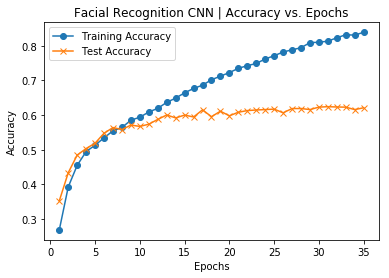

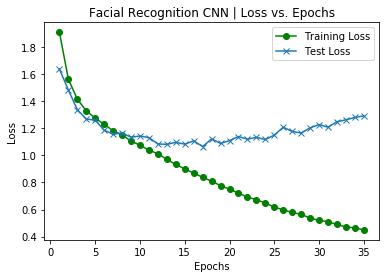

In [17]:
# Create Arrays for Loss and Accouracy
import numpy as np
import matplotlib.pyplot as plt

x_epoch = np.array(range(35)) + 1
train_loss = np.array([1.9119, 1.5642, 1.4164, 1.3306, 1.2757, 1.2304, 1.1826, 1.1522, 1.1066, 1.0764, 1.0394, 1.0130, 0.9703, 0.9336, 0.9010, 0.8685, 0.8390, 0.8091, 0.7773, 0.7498, 0.7218, 0.6930, 0.6723, 0.6479, 0.6183, 0.5979, 0.5779, 0.5650, 0.5358, 0.5202, 0.5094, 0.4891, 0.4705, 0.4646, 0.4490])
val_loss = np.array([1.6394, 1.4840, 1.3392, 1.2697, 1.2614, 1.1867, 1.1586, 1.1655, 1.1352, 1.1440, 1.1321, 1.0851, 1.0824, 1.0971, 1.0835, 1.1083, 1.0659, 1.1224, 1.0891, 1.1099, 1.1403, 1.1208, 1.1338, 1.1183, 1.1505, 1.2087, 1.1780, 1.1658, 1.2041, 1.2286, 1.2096, 1.2496, 1.2638, 1.2810, 1.2929])
train_acc = np.array([0.2680, 0.3923, 0.4548, 0.4946, 0.5130, 0.5343, 0.5545, 0.5643, 0.5852, 0.5939, 0.6089, 0.6195, 0.6368, 0.6491, 0.6644, 0.6769, 0.6865, 0.7021, 0.7126, 0.7229, 0.7351, 0.7428, 0.7492, 0.7622, 0.7716, 0.7823, 0.7887, 0.7947, 0.8095, 0.8105, 0.8137, 0.8235, 0.8322, 0.8312, 0.8395])
val_acc = np.array([0.3520, 0.4334, 0.4844, 0.5033, 0.5188, 0.5475, 0.5639, 0.5581, 0.5711, 0.5673, 0.5736, 0.5875, 0.6003, 0.5918, 0.6000, 0.5945, 0.6151, 0.5954, 0.6112, 0.5979, 0.6082, 0.6130, 0.6147, 0.6159, 0.6172, 0.6066, 0.6188, 0.6190, 0.6159, 0.6230, 0.6243, 0.6234, 0.6229, 0.6159, 0.6211])

plt.figure(1)
plt.plot(x_epoch, train_acc, '-o')
plt.plot(x_epoch, val_acc, '-x')
plt.legend(['Training Accuracy', 'Test Accuracy'], loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Facial Recognition CNN | Accuracy vs. Epochs')

plt.figure(2)
plt.plot(x_epoch, train_loss, '-o', color='green')
plt.plot(x_epoch, val_loss, '-x')
plt.legend(['Training Loss', 'Test Loss'], loc=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Facial Recognition CNN | Loss vs. Epochs')

In [ ]:
# Plot Accuracies and Loss
def big_plotter(hist):
    # Plot Accuracies
    f, ax = plt.subplots()
    acc_train = hist.history['acc']
    acc_test = hist.history['val_acc']
    ax.plot(acc_train, 'o-')
    ax.plot(acc_test, 'x-')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy vs. Epoch')
    ax.legend(['Training Accuracy', 'Test Accuracy'], loc=0)
    
    # Plot Losses
    f, ax = plt.subplots()
    loss_train = hist.history['loss']
    loss_test = hist.history['val_loss']
    ax.plot(loss_train, 'o-')
    ax.plot(loss_test, 'x-')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Loss')
    ax.set_title('Loss vs. Epoch')
    ax.legend(['Training Loss', 'Test Loss'], loc=0)

In [23]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(10,7))

# Training accuracy
plt.subplot(221)
plt.plot(range(0,35), history.history['acc'], c = 'forestgreen');
plt.title('Training accuracy per epoch');

# Training loss #
plt.subplot(222)
plt.plot(range(0,35), history.history['loss'], c = 'forestgreen');
plt.title('Training loss per epoch');

# Validation accuracy #
plt.subplot(223)
plt.plot(range(0,35), history.history['val_acc'], c = 'blue');
plt.title('Validation accuracy per epoch');

# Validation loss #
plt.subplot(224)
plt.plot(range(0,35), history.history['val_loss'], c = 'blue');
plt.title('Validation loss per epoch');

/home/rlangergaard/ENTER/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [27]:
print("Final test accuracy = %s%%" % (history.history['val_acc'][-1]*100))

Final test accuracy = 62.10643633324045%


In [29]:
face_CNN.save('face_cnn_model.h5')

## CNN Pickle

In [28]:
from keras.models import load_model

model = load_model('face_cnn_model.h5')

In [29]:
#model.weights

In [33]:
import pickle
import dill

In [48]:
y_pred_model = model.predict(X_test)


NameError: name 'y_pred' is not defined

In [47]:
mod = dill.load(open('face_CNN.pickle', 'rb'))

y_pred_pickle = mod.predict(X_test)


In [57]:
print('First prediction from saved model =', y_pred_model[0])
print('First prediction from pickle model =', y_pred_pickle[0])

First prediction from saved model = [0.34562925 0.00704463 0.11611738 0.0027287  0.38321576 0.00087468
 0.14438967]
First prediction from pickle model = [0.34562925 0.00704463 0.11611738 0.0027287  0.38321576 0.00087468
 0.14438967]


In [72]:
a = y_pred_model
print(a.shape)
a_new = a.argmax(axis = 1)
print(a_new.shape)
print(a_new[0:10])

(7178, 7)
(7178,)
[4 1 0 4 3 3 4 4 3 2]


In [42]:
import types
import tempfile
import keras.models

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

In [43]:
import keras
import pickle

make_keras_picklable()

pickle.dumps(model)

In [28]:

#This works like a charm http://zachmoshe.com/2017/04/03/pickling-keras-models.html:

import types
import tempfile
import keras.models

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

make_keras_picklable()

In [ ]:
import dill

filename = 'face_CNN.pickle'

pickle_out = open(filename, 'wb')

dill.dump(model, pickle_out)

#dill.dumps(model, pickle_out)

pickle_out.close()

## Turn CNN predictions into the same predictions as MoodyLyrics

The mood in the fer2013 facial image data is labeled as follows:

| Mood | Code  |
| --- | --- |
| Angry | 0 |
| Disgust | 1 |
| Fear | 2 |
| Happy | 3 |
| Sad | 4 |
| Surprised | 5 |
| Neutral | 6 |

Where the MoodyLyrics dataset only have the following four categories:

| Mood | Code  |
| --- | --- |
| Happy | 0 |
| Angry | 1 |
| Sad | 2 |
| Relaxed | 3 |


To combine the two datasets the following generalization will be made:

| Fer2013 Mood | MoodyLyrics mood |
| --- | --- |
| Happy | Happy |
| Fear, Sad | Sad |
| Angry, disgust | Angry |
| Surprised, Neutral | Relaxed |

In [78]:
def face_to_moodlyr(y_pred):
    new_pred = []
    for pred in y_pred:
        if pred == 3:
            new_pred.append(0)
        elif pred == 0 or pred == 1:
            new_pred.append(1)
        elif pred == 2 or pred == 4:
            new_pred.append(2)
        else:
            new_pred.append(3)
    return np.array(new_pred)

In [85]:
ml_pred = face_to_moodlyr(a_new)
print('Shape of ml_pred array:', ml_pred.shape)

print('Predictions in ml_pred:', set(ml_pred))

Shape of ml_pred array: (7178,)
Predictions in ml_pred: {0, 1, 2, 3}
